# 2D subsurface so 1D survey, 2D inversion

## vary removing survey data at different points and see how relatively good/bad the inversion is 

In [530]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile
from discretize.utils import mkvc
from scipy.interpolate import LinearNDInterpolator


from discretize import TensorMesh

from SimPEG.potential_fields import magnetics
from SimPEG.utils import plot2Ddata, surface2ind_topo, model_builder
from SimPEG import (
    maps,
    data,
    inverse_problem,
    data_misfit,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

# sphinx_gallery_thumbnail_number = 3

In [531]:
# storage bucket where we have the data
#data_source = "https://storage.googleapis.com/simpeg/doc-assets/magnetics.tar.gz"

# download the data
#downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
#tar = tarfile.open(downloaded_data, "r")
#tar.extractall()
#tar.close()

# path to the directory containing our data
#dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
#topo_filename = dir_path + "magnetics_topo.txt"
#data_filename = dir_path + "magnetics_data.obs"

In [532]:
#topo_xyz = np.loadtxt(str(topo_filename))
[x_topo, y_topo] = np.meshgrid(np.linspace(-200, 200, 41), np.linspace(-200, 200, 41))
z_topo = np.zeros(len(x_topo)*len(y_topo)) #-15 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]
topo_xyz


array([[-200., -200.,    0.],
       [-200., -190.,    0.],
       [-200., -180.,    0.],
       ...,
       [ 200.,  180.,    0.],
       [ 200.,  190.,    0.],
       [ 200.,  200.,    0.]])

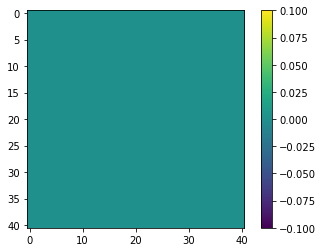

In [533]:
plt.imshow(z_topo.reshape(41,41))
plt.colorbar()

In [534]:
topo_xyz.shape

(1681, 3)

In [535]:
# Define the observation locations as an (N, 3) numpy array or load them.
x = np.linspace(-80.0, 80.0, 17)
y = np.linspace(-20.0, 20.0, 2)
x, y = np.meshgrid(x, y)
x, y = mkvc(x.T), mkvc(y.T)
fun_interp = LinearNDInterpolator(np.c_[x_topo, y_topo], z_topo)
z = fun_interp(np.c_[x, y]) + 10  # Flight height 10 m above surface.
receiver_locations = np.c_[x, y, z]

# Define the component(s) of the field we want to simulate as a list of strings.
# Here we simulation total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000
inducing_field = (strength, inclination, declination)

source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

In [536]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 2)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

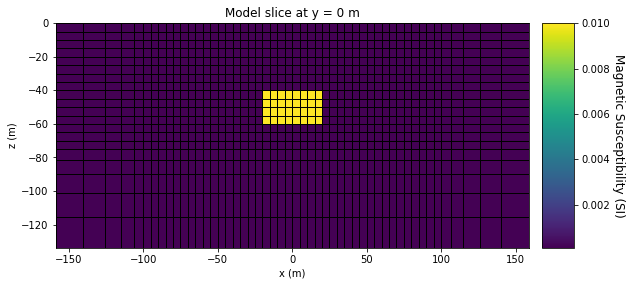

In [537]:
# Define susceptibility values for each unit in SI
background_susceptibility = 0.0001
sphere_susceptibility = 0.01

# Find cells that are active in the forward modeling (cells below surface)
ind_active = surface2ind_topo(mesh, topo_xyz)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model is a vlue for each active cell

# Define model. Models in SimPEG are vector arrays
model = background_susceptibility * np.ones(ind_active.sum())
ind_sphere = model_builder.getIndicesSphere(
    np.r_[0.0, 0.0, -45.0], 15.0, mesh.cell_centers
)

ind_block = (
    (mesh.gridCC[ind_active, 0] > -20.0) #x
    & (mesh.gridCC[ind_active, 0] < 20.0)
    & (mesh.gridCC[ind_active, 1] > -30.0) #y
    & (mesh.gridCC[ind_active, 1] < 30.0)
    & (mesh.gridCC[ind_active, 2] > -60.0) #z
    & (mesh.gridCC[ind_active, 2] < -40.0)
)

ind_sphere = ind_sphere[ind_active]

model[ind_block] = sphere_susceptibility



# Plot Model
fig = plt.figure(figsize=(9, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label("Magnetic Susceptibility (SI)", rotation=270, labelpad=15, size=12)

plt.show()

In [538]:
ind_sphere.shape

(2000,)

In [539]:
# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    actInd=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for a susceptibility model
dpred = simulation.dpred(model)


In [540]:
dobs = dpred
receiver_locations = np.c_[x, y, z]


In [541]:
dobs.shape

(34,)

In [542]:
receiver_locations
rl = receiver_locations

In [543]:
rl

array([[-80., -20.,  10.],
       [-70., -20.,  10.],
       [-60., -20.,  10.],
       [-50., -20.,  10.],
       [-40., -20.,  10.],
       [-30., -20.,  10.],
       [-20., -20.,  10.],
       [-10., -20.,  10.],
       [  0., -20.,  10.],
       [ 10., -20.,  10.],
       [ 20., -20.,  10.],
       [ 30., -20.,  10.],
       [ 40., -20.,  10.],
       [ 50., -20.,  10.],
       [ 60., -20.,  10.],
       [ 70., -20.,  10.],
       [ 80., -20.,  10.],
       [-80.,  20.,  10.],
       [-70.,  20.,  10.],
       [-60.,  20.,  10.],
       [-50.,  20.,  10.],
       [-40.,  20.,  10.],
       [-30.,  20.,  10.],
       [-20.,  20.,  10.],
       [-10.,  20.,  10.],
       [  0.,  20.,  10.],
       [ 10.,  20.,  10.],
       [ 20.,  20.,  10.],
       [ 30.,  20.,  10.],
       [ 40.,  20.,  10.],
       [ 50.,  20.,  10.],
       [ 60.,  20.,  10.],
       [ 70.,  20.,  10.],
       [ 80.,  20.,  10.]])

In [544]:
rl[[0,17,2,19, 3, 20]] #choose 3 survey positions
rl[[3,20,6,23, 12, 29]] #choose 3 survey positions

array([[-50., -20.,  10.],
       [-50.,  20.,  10.],
       [-20., -20.,  10.],
       [-20.,  20.,  10.],
       [ 40., -20.,  10.],
       [ 40.,  20.,  10.]])

In [545]:
#remove some values
#dobs2 = np.delete(dobs, np.where(condition1)[0])
#rl2 = np.delete(rl, np.where(condition1)[0], 0)

p1 = [0,17,2,19, 14, 31, 16, 33] #positions, to the far left and far right, decent results

p2 = [4,21, 5, 22,6,23, 7, 24] # points close to centre

p3  = [0,17,5,22, 10, 27, 16, 33]

dobs2 = dobs[p1]
rl2 = rl[p1]

In [546]:
rl2

array([[-80., -20.,  10.],
       [-80.,  20.,  10.],
       [-60., -20.,  10.],
       [-60.,  20.,  10.],
       [ 60., -20.,  10.],
       [ 60.,  20.,  10.],
       [ 80., -20.,  10.],
       [ 80.,  20.,  10.]])

In [547]:
dobs = dobs2
receiver_locations = rl2


In [548]:
receiver_locations

array([[-80., -20.,  10.],
       [-80.,  20.,  10.],
       [-60., -20.,  10.],
       [-60.,  20.,  10.],
       [ 60., -20.,  10.],
       [ 60.,  20.,  10.],
       [ 80., -20.,  10.],
       [ 80.,  20.,  10.]])

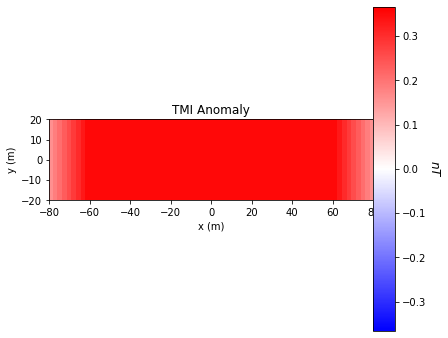

In [549]:

#observed data:
#dobs = np.loadtxt(str(data_filename))
#receiver_locations = dobs[:, 0:3]





# Plot
fig = plt.figure(figsize=(6, 5))
v_max = np.max(np.abs(dobs))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(
    receiver_locations,
    dobs,
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "bwr"},
)
ax1.set_title("TMI Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.85, 0.05, 0.05, 0.9])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=np.max(np.abs(dobs)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr
)
cbar.set_label("$nT$", rotation=270, labelpad=15, size=12)

plt.show()

In [550]:
maximum_anomaly = np.max(np.abs(dobs))

std = 0.02 * maximum_anomaly * np.ones(len(dobs))

In [551]:
# Define the component(s) of the field we are inverting as a list. Here we will
# invert total magnetic intensity data.
components = ["tmi"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = magnetics.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000
inducing_field = (strength, inclination, declination)

source_field = magnetics.sources.SourceField(
    receiver_list=receiver_list, parameters=inducing_field
)

# Define the survey
survey = magnetics.survey.Survey(source_field)

In [552]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=std)


In [553]:
# Define background susceptibility model in SI. Don't make this 0!
# Otherwise the gradient for the 1st iteration is zero and the inversion will
# not converge.
background_susceptibility = 1e-4

# Find the indecies of the active cells in forward model (ones below surface)
ind_active = surface2ind_topo(mesh, topo_xyz)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each cell

# Define starting model
starting_model = background_susceptibility * np.ones(nC)

In [554]:
# Define the problem. Define the cells below topography and the mapping
simulation = magnetics.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    model_type="scalar",
    chiMap=model_map,
    actInd=ind_active,
)

In [555]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh,
    indActive=ind_active,
    mapping=model_map,
    mref=starting_model,
    gradientType="total",
    alpha_s=1,
    alpha_x=1,
    alpha_y=1,
    alpha_z=1,
)

# Define sparse and blocky norms p, qx, qy, qz
reg.norms = np.c_[0, 2, 2, 2]

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=0.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [556]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Defines the directives for the IRLS regularization. This includes setting
# the cooling schedule for the trade-off parameter.
update_IRLS = directives.Update_IRLS(
    f_min_change=1e-4,
    max_irls_iterations=30,
    coolEpsFact=1.5,
    beta_tol=1e-2,
)

# Updating the preconditioner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    save_iteration,
    update_IRLS,
    update_jacobi,
]

In [557]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Print target misfit to compare with convergence
# print("Target misfit is " + str(target_misfit.target))

# Run the inversion
recovered_model = inv.run(starting_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.00e+06  2.20e+03  0.00e+00  2.20e+03    4.02e+01      0              
   1  1.50e+06  3.56e+02  1.40e-04  5.66e+02    3.82e+01      0              
   2  7.50e+05  1.71e+02  2.26e-04  3.41e+02    3.74e+01      0   Skip BFGS  
   3  3.75e+05  7.07e+01  3.18e-04  1.90e+02    3.67e+01      0   Skip BFGS  
   4  1.88e+05  2.46e+01  4.01e-04  9.98e+01    3.66e+01      0   Skip BFGS  
   5  9.38e+04  7.55e+00  4.62e-04  5.09e+01    3.62e+01      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.0003467187700481096 eps_q: 0.

In [558]:
background_susceptibility = 0.0001
sphere_susceptibility = 0.01

true_model = model
"""
background_susceptibility * np.ones(nC)
ind_sphere = model_builder.getIndicesSphere(
    np.r_[0.0, 0.0, -45.0], 15.0, mesh.cell_centers
)
ind_sphere = ind_sphere[ind_active]
true_model[ind_sphere] = sphere_susceptibility
"""

'\nbackground_susceptibility * np.ones(nC)\nind_sphere = model_builder.getIndicesSphere(\n    np.r_[0.0, 0.0, -45.0], 15.0, mesh.cell_centers\n)\nind_sphere = ind_sphere[ind_active]\ntrue_model[ind_sphere] = sphere_susceptibility\n'

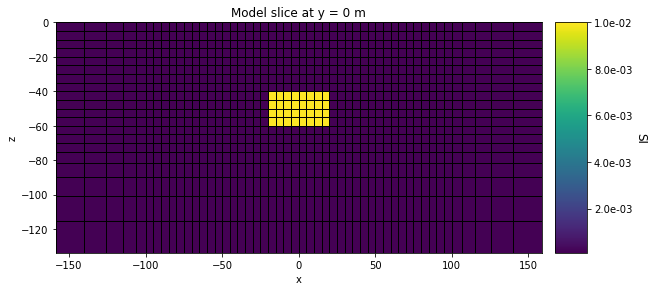

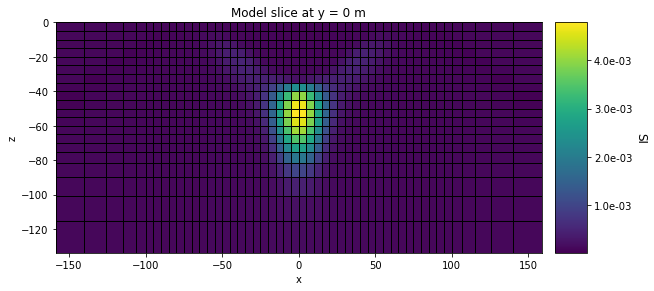

In [559]:
# Plot True Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.08, 0.1, 0.75, 0.8])
mesh.plotSlice(
    plotting_map * true_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(true_model), np.max(true_model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis, format="%.1e"
)
cbar.set_label("SI", rotation=270, labelpad=15, size=12)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.08, 0.1, 0.75, 0.8])
mesh.plotSlice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis, format="%.1e"
)
cbar.set_label("SI", rotation=270, labelpad=15, size=12)

plt.show()

In [560]:
def RMS(real, generated): #compares rms of real and generated model
    return np.sqrt(np.average((generated-real)**2))



In [561]:
RMS(true_model, recovered_model) 
#there are some positions which work better than others...
#although RMS may be misleading in some cases


0.001327505100388124

In [453]:
int(mesh.nCy / 2)

1

In [454]:
mesh.nCy

2

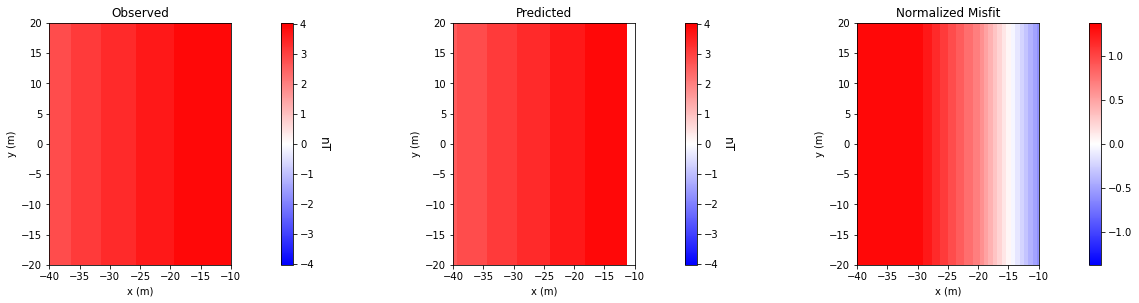

In [455]:
# Predicted data with final recovered model
dpred = inv_prob.dpred

# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs, dpred, (dobs - dpred) / std]

fig = plt.figure(figsize=(17, 4))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["nT", "nT", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(data_array[:, 2]))]

for ii in range(0, 3):

    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.25, 0.84])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "bwr"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.27, 0.11, 0.01, 0.84])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)

plt.show()